In [2]:
from mylib.statistic_test import *

code_id = '0038 - Half-half Correlation'
loc = os.path.join(figpath, code_id)
mkdir(loc)
pass

d:\SoftwareData\Anaconda\envs\maze\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


        D:\Data\FinalResults\0038 - Half-half Correlation is already existed!


In [3]:
def get_corr(trace: dict):
    """
    Calculate the stability of ROIs
    """
    corr = np.zeros(trace['n_neuron']) * np.nan
    for i in range(trace['n_neuron']):
        if trace['is_placecell'][i] == 0:
            continue
        
        corr[i] = np.corrcoef(
            trace['smooth_map_fir'][i, :], 
            trace['smooth_map_sec'][i, :]
        )[0, 1]
    return np.nanmean(corr)

if os.path.exists(os.path.join(figdata, f'{code_id}.pkl')) == False:
    CorrData = {
        "MiceID": [],
        "Training Day": [],
        "Correlation": [],
        "Maze Type": [],
        "Stage": []
    }
    
    for mouse in [10209, 10212, 10224, 10227, 10232, 10234]:
        for i, stage in enumerate(['Stage 1', 'Stage 2']):
            print(f"{mouse} {stage}")
            for training_day in tqdm([f"Day {j}" for j in range(1, 14)]):
                idx = np.where(
                    (f1['MiceID'] == mouse) & 
                    (f1['training_day'] == training_day) & 
                    (f1['Stage'] == stage)
                )[0]
                if np.sum(f1['include'][idx]) < idx.shape[0]:
                    continue
                
                # Two Sessions of Open Field are not run
                if mouse == 10232 and stage == 'Stage 2' and training_day == 'Day 6':
                    # Mouse 10232, 20241004 Session 4 is missed.
                    with open(join(f1['Trace File'][idx[0]]), 'rb') as handle:
                        trace_op1 = pickle.load(handle)
                    corr_op = get_corr(trace_op1)
                    del trace_op1
                elif mouse == 10234 and stage == 'Stage 2' and training_day == 'Day 6': 
                    with open(join(f1['Trace File'][idx[-1]]), 'rb') as handle:
                        trace_op2 = pickle.load(handle)                     
                    corr_op = get_corr(trace_op2)
                    del trace_op2
                else:
                    with open(join(f1['Trace File'][idx[0]]), 'rb') as handle:
                        trace_op1 = pickle.load(handle)
                    with open(join(f1['Trace File'][idx[1]]), 'rb') as handle:
                        trace_op2 = pickle.load(handle)
                    corr_op = (get_corr(trace_op1) + get_corr(trace_op2))/2
                    
                    del trace_op1, trace_op2
                    
                with open(join(f1['Trace File'][idx[1]]), 'rb') as handle:
                    trace_m1 = pickle.load(handle)
                    
                corr_m1 = get_corr(trace_m1)
                
                if stage == 'Stage 1':
                    assert len(idx) == 3
                    CorrData['MiceID'].append(np.repeat(mouse, 2))
                    CorrData['Training Day'].append(np.repeat(training_day, 2))
                    CorrData['Correlation'].append([corr_op, corr_m1])
                    CorrData['Maze Type'].append(['Open Field', 'Maze A'])
                    CorrData['Stage'].append(np.repeat(stage, 2))                    
                    
                elif stage == 'Stage 2':
                    assert len(idx) == 4                
                    with open(join(f1['Trace File'][idx[2]]), 'rb') as handle:
                        trace_m2 = pickle.load(handle)  
                    corr_m2 = get_corr(trace_m2)
                    
                    CorrData['MiceID'].append(np.repeat(mouse, 3))
                    CorrData['Training Day'].append(np.repeat(training_day, 3))
                    CorrData['Correlation'].append([corr_op, corr_m1, corr_m2])
                    CorrData['Maze Type'].append(['Open Field', 'Maze A', 'Maze B'])
                    CorrData['Stage'].append(np.repeat(stage, 3))
                    
    for k in CorrData.keys():
        CorrData[k] = np.concatenate(CorrData[k])
    
    with open(join(figdata, f'{code_id}.pkl'), 'wb') as handle:
        pickle.dump(CorrData, handle)
    
    CorrD = pd.DataFrame(CorrData)
    CorrD.to_excel(os.path.join(figdata, code_id + '.xlsx'), index=False)
    print(len(CorrD))
else:
    with open(os.path.join(figdata, f'{code_id}.pkl'), 'rb') as handle:
        CorrData = pickle.load(handle)

# Fig. S3D and S3E

C:\Users\12454\AppData\Local\Temp\ipykernel_18204\781672055.py:5: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.lineplot(


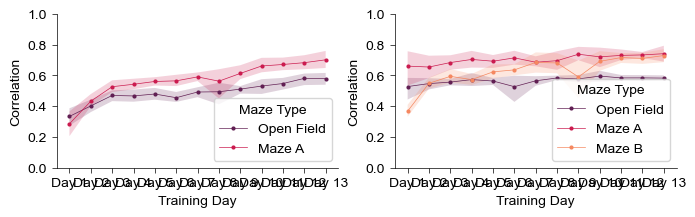

In [5]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 2))
ax0 = Clear_Axes(axes[0], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
ax1 = Clear_Axes(axes[1], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
SubData1 = SubDict(CorrData, CorrData.keys(), np.where(CorrData['Stage'] == 'Stage 1')[0])
sns.lineplot(
    x='Training Day',
    y='Correlation',
    hue='Maze Type',
    data=SubData1,
    ax=ax0,
    palette=MazePalette,
    linewidth=0.5,
    err_kws={'edgecolor': None},
    marker='o',
    markersize=3,
    markeredgewidth=0
    #err_style='bars',
    #err_kws={'capsize': 2, 'elinewidth': 0.5, 'capthick': 0.5}
)
SubData2 = SubDict(CorrData, CorrData.keys(), np.where(CorrData['Stage'] == 'Stage 2')[0])
sns.lineplot(
    x='Training Day',
    y='Correlation',
    hue='Maze Type',
    data=SubData2,
    ax=ax1,
    palette=MazePalette,
    linewidth=0.5,
    err_kws={'edgecolor': None},
    marker='o',
    markersize=3,
    markeredgewidth=0
    #err_style='bars',
    #err_kws={'capsize': 2, 'elinewidth': 0.5, 'capthick': 0.5}
)
ax0.set_ylim(0, 1)
ax1.set_ylim(0, 1)
plt.savefig(join(loc, "Half-half correlation.svg"))
plt.savefig(join(loc, "Half-half correlation.png"), dpi=600)
plt.show()

# Statistics (Fig. S3F)

Open Field: TtestResult(statistic=-7.6404833088610165, pvalue=0.0006111123139781004, df=5)
Maze A: TtestResult(statistic=-7.22060321692908, pvalue=0.0007944884859943733, df=5)
Maze B: TtestResult(statistic=-10.782575204826651, pvalue=0.00011898150652186173, df=5)


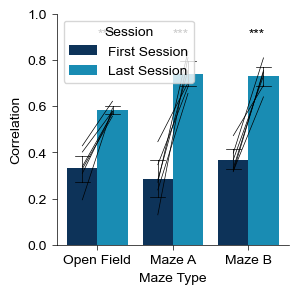

In [8]:
if exists(join(figdata, f'{code_id} [Statistics].pkl')) == False:
    StatData = {
        "MiceID": [],
        "Session": [],
        "Correlation": [],
        "Maze Type": []
    }
    
    for mouse in [10209, 10212, 10224, 10227, 10232, 10234]:
        for maze_type in ['Open Field', 'Maze A', 'Maze B']:
            if maze_type in ['Open Field', 'Maze A']:
                idx_bef = np.where(
                    (CorrData['MiceID'] == mouse) & 
                    (CorrData['Maze Type'] == maze_type) &
                    (CorrData['Stage'] == 'Stage 1') &
                    (CorrData['Training Day'] == 'Day 1')
                )[0]
            else:
                idx_bef = np.where(
                    (CorrData['MiceID'] == mouse) & 
                    (CorrData['Maze Type'] == maze_type) &
                    (CorrData['Stage'] == 'Stage 2') &
                    (CorrData['Training Day'] == 'Day 1')
                )[0]
                
            idx_aft = np.where(
                (CorrData['MiceID'] == mouse) & 
                (CorrData['Maze Type'] == maze_type) &
                (CorrData['Stage'] == 'Stage 2') &
                (CorrData['Training Day'] == 'Day 13')
            )[0]
            
            StatData['MiceID'].append([mouse, mouse])
            StatData['Session'].append(['First Session', 'Last Session'])
            StatData['Correlation'].append([CorrData['Correlation'][idx_bef[0]], CorrData['Correlation'][idx_aft[0]]])
            StatData['Maze Type'].append([maze_type, maze_type])

    for k in StatData.keys():
        StatData[k] = np.concatenate(StatData[k])
        
    StatD = pd.DataFrame(StatData)
    with open(join(figdata, f'{code_id} [Statistics].pkl'), 'wb') as handle:
        pickle.dump(StatD, handle)
    StatD.to_excel(os.path.join(figdata, f'{code_id} [Statistics].xlsx'), index=False)
    print(len(StatD))
else:
    with open(os.path.join(figdata, f'{code_id} [Statistics].pkl'), 'rb') as handle:
        StatData = pickle.load(handle)

fig = plt.figure(figsize=(3, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.barplot(
    x='Maze Type',
    y='Correlation',
    hue='Session',
    data=StatData,
    ax=ax,
    palette=['#003366', '#0099CC'],
    linewidth=0.5,
    err_kws={'color': 'k', 'linewidth': 0.5},
    capsize=0.4,
    width=0.8
)
for i, maze_type in enumerate(['Open Field', 'Maze A', 'Maze B']):
    idx0 = np.where(
        (StatData['Maze Type'] == maze_type) & 
        (StatData['Session'] == 'First Session')
    )[0]
    idx1 = np.where(
        (StatData['Maze Type'] == maze_type) & 
        (StatData['Session'] == 'Last Session')
    )[0]
    print(f"{maze_type}: {ttest_rel(StatData['Correlation'][idx0], StatData['Correlation'][idx1])}")
    for j in range(idx0.shape[0]):
        ax.plot(
            [i - 0.2, i + 0.2],
            [StatData['Correlation'][idx0[j]], StatData['Correlation'][idx1[j]]],
            color='k',
            linewidth=0.5
        )
ax.set_ylim(0, 1)
ax.text(0, 0.9, '***')
ax.text(1, 0.9, '***')
ax.text(2, 0.9, '***')
plt.savefig(join(loc, "Half-half correlation statistics.svg"))
plt.savefig(join(loc, "Half-half correlation statistics.png"), dpi=600)
plt.show()
